In [4]:
import pandas as pd
import datetime as dt
import backtrader as bt
import quantstats as qs
import matplotlib as plt
import numpy as np
import os
import pathlib

os.getcwd()

# 数据加载-------------------------------------
df = pd.read_csv(pathlib.Path.cwd() / ".." / "data"/ "testCSI905.csv")  # 绝对路径
# df = pd.read_csv("backtest.csv")  # 绝对路径
df.index = pd.to_datetime(df.date)
df['openinterest'] = 0

# #以下是自己随机添加signal的之后的文件，hmm算法给出的带signal的文件直接用上面的df=pd.read_csv导入，把下面到构建策略之前mute掉即可

# #随机生成一个-1，0，1的predictions序列---------
# sig=[]
# for i in range(len(df)):
#     x=np.random.randn()
#     if x > 0.2:
#         sig.append(1)
#     elif x<-0.2:
#         sig.append(-1)
#     else:
#         sig.append(0)
# df['signal']=sig


# 构建策略-------------------------------------
class TestSignalStrategy(bt.Strategy):
    params = ()

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s,%s' % (dt.isoformat(), txt))

    def __init__(self):
        self.bar_num = 0
        self.signal_df = df
        self.signal_df['date'] = pd.to_datetime(self.signal_df['date'])
        self.first_trade = True

    def prenext(self):
        self.next()

    def next(self):
        self.bar_num += 1
        current_date = self.datas[0].datetime.date(0).strftime("%Y-%m-%d")
        try:
            next_date = self.datas[0].datetime.date(1)
        except:
            next_date = None
        if next_date != None:
            next_signal_df = self.signal_df[self.signal_df['date'] == pd.to_datetime(
                next_date)]
            if len(next_signal_df) == 0:
                self.log("下个交易日的信号不存在")
            else:
                signal = int(next_signal_df['signal'])

                # 第一次交易没有底仓，只允许做多
                # 交易信号的执行方式：
                # 先不考虑卖空
                # signal为1，以当天开盘价全仓买入
                # signal为-1时，以当天开盘价卖出所有持仓
                if self.first_trade:
                    if signal == -1:
                        pass
                    if signal == 1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size = total_value//open_price
                        self.buy(self.datas[0],
                                 size=target_size, price=open_price)
                        self.first_trade = False
                else:
                    # 现有持仓
                    now_hold_size = self.getposition(self.datas[0]).size
                    if signal == 1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size = total_value//open_price
                        self.buy(self.datas[0],
                                 size=target_size, price=open_price)

                    if signal == -1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size = total_value//open_price
                        # 卖出开仓，手数不能超过底仓
                        if target_size > now_hold_size:
                            target_size = now_hold_size

                        self.sell(
                            self.datas[0], size=target_size, price=open_price)

    # 订单情况
    def notify_order(self, order):

        # 订单处于未决，继续
        if order.status in [order.Submitted, order.Accepted]:
            return

        # 订单已决
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行,%.2f' % order.executed.price)

            elif order.issell():
                self.log('卖单执行,%2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Rejected, order.Expired]:
            self.log('订单 Canceled/Rejected/Expired')

    # 交易情况
    def notify_trade(self, trade):
        if trade.isclosed:
            print('毛收益 %0.2f, 扣佣后收益 % 0.2f , 佣金 %.2f'
                  % (trade.pnl, trade.pnlcomm, trade.commission))


cerebro = bt.Cerebro()

stock_df = df[['open', 'high', 'low', 'close', 'volume', 'openinterest']]
# print(stock_df)
data = bt.feeds.PandasData(dataname=stock_df, fromdate=dt.datetime(
    2010, 1, 4), todate=dt.datetime(2021, 12, 31), timeframe=bt.TimeFrame.Days)
cerebro.adddata(data)

# 初始资金设置为10万
cerebro.broker.setcash(100000.0)
# 手续费万分之二
cerebro.broker.setcommission(commission=0.0002)
# 滑点设置 0.5%
cerebro.broker = bt.brokers.BackBroker(slip_perc=0.005)

cerebro.addstrategy(TestSignalStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

# 运行回测
print('start portfolio value:', format(cerebro.broker.getvalue()))
results = cerebro.run()
print('end portfolio value:', format(cerebro.broker.getvalue()))


# 绩效评价----------------------------
# 获取策略实例
start = results[0]
portfolio_stats = start.analyzers.getbyname('PyFolio')
# 以下returns为以日期为索引的资产日收益率序列
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

start portfolio value: 10000.0
2014-03-10,买单执行,3981.51
2014-03-12,卖单执行,3857.580000
毛收益 -247.86, 扣佣后收益 -247.86 , 佣金 0.00
2014-03-20,买单执行,3973.15
2014-03-31,卖单执行,3865.000000
毛收益 -216.30, 扣佣后收益 -216.30 , 佣金 0.00
2014-04-09,买单执行,3987.43
2014-04-22,卖单执行,3957.220000
毛收益 -60.42, 扣佣后收益 -60.42 , 佣金 0.00
2014-05-12,买单执行,3738.67
2014-05-16,卖单执行,3722.560000
毛收益 -32.22, 扣佣后收益 -32.22 , 佣金 0.00
2014-05-27,买单执行,3825.37
2014-06-10,卖单执行,3801.510000
毛收益 -47.72, 扣佣后收益 -47.72 , 佣金 0.00
2014-06-11,买单执行,3838.67
2014-06-23,卖单执行,3790.840000
毛收益 -95.66, 扣佣后收益 -95.66 , 佣金 0.00
2014-06-30,买单执行,3895.15
2014-07-24,卖单执行,4055.140000
毛收益 319.98, 扣佣后收益  319.98 , 佣金 0.00
2014-07-28,买单执行,4106.99
2014-08-28,卖单执行,4423.760000
毛收益 633.54, 扣佣后收益  633.54 , 佣金 0.00
2014-09-04,买单执行,4611.56
2014-10-20,卖单执行,4873.450000
毛收益 523.78, 扣佣后收益  523.78 , 佣金 0.00
2014-10-30,买单执行,4988.97
2014-11-13,卖单执行,4963.730000
毛收益 -50.48, 扣佣后收益 -50.48 , 佣金 0.00
2014-11-21,买单执行,4975.53
2014-12-23,卖单执行,5273.990000
毛收益 596.92, 扣佣后收益  596.92 , 佣金 0.00
2015

2021-07-29,卖单执行,6720.620000
毛收益 -181.19, 扣佣后收益 -181.19 , 佣金 0.00
2021-08-06,买单执行,6929.02
2021-08-20,卖单执行,6915.020000
毛收益 -14.00, 扣佣后收益 -14.00 , 佣金 0.00
2021-08-26,买单执行,7151.53
2021-09-22,卖单执行,7305.080000
毛收益 153.55, 扣佣后收益  153.55 , 佣金 0.00
2021-10-21,买单执行,7127.64
2021-10-29,卖单执行,6955.850000
毛收益 -171.79, 扣佣后收益 -171.79 , 佣金 0.00
2021-11-09,买单执行,7037.57
2021-12-03,卖单执行,7233.570000
毛收益 196.00, 扣佣后收益  196.00 , 佣金 0.00
2021-12-06,买单执行,7308.99
2021-12-21,卖单执行,7190.970000
毛收益 -118.02, 扣佣后收益 -118.02 , 佣金 0.00
2021-12-30,买单执行,7246.03
end portfolio value: 11781.949999999997


                    Strategy
------------------  ----------
Start Period        2014-03-07
End Period          2021-12-30
Risk-Free Rate      0.0%
Time in Market      67.0%

Cumulative Return   17.82%
CAGR﹪              2.12%

Sharpe              0.22
Sortino             0.29
Sortino/√2          0.21
Omega               1.05

Max Drawdown        -40.34%
Longest DD Days     2351

Gain/Pain Ratio     0.05
Gain/Pain (1M)      0.2

Payoff Ratio        0.95
Profit Factor       1.05
Common Sense Ratio  1.14
CPC Index           0.52
Tail Ratio          1.08
Outlier Win Ratio   7.04
Outlier Loss Ratio  4.47

MTD                 -0.61%
3M                  -0.24%
6M                  -1.39%
YTD                 -3.66%
1Y                  -3.69%
3Y (ann.)           0.11%
5Y (ann.)           -4.0%
10Y (ann.)          2.12%
All-time (ann.)     2.12%

Avg. Drawdown       -3.98%
Avg. Drawdown Days  114
Recovery Factor     0.44
Ulcer Index         0.28
Serenity Index      0.01


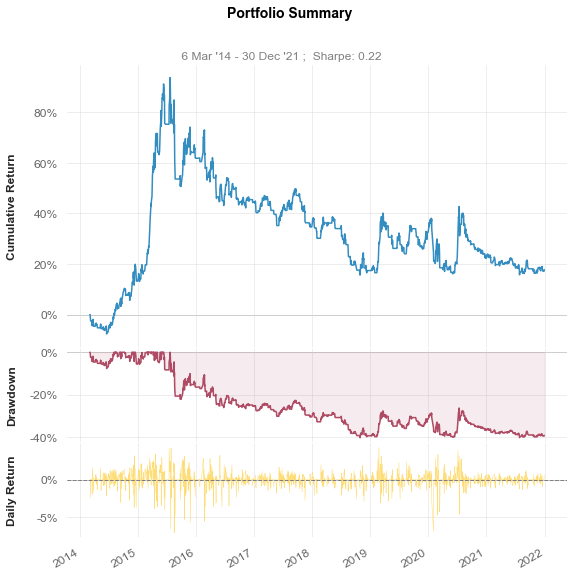

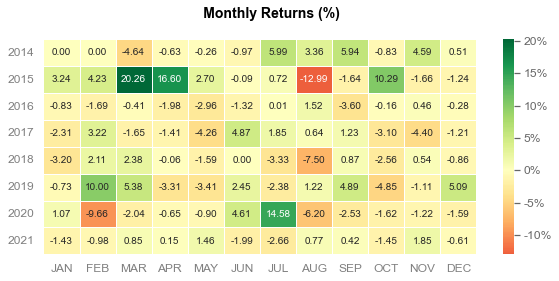

In [5]:
# 画图仍只能在notebook中输出(将basic改成full的话可以得到更多的输出结果，但其中一个return distribution的表会报错)
qs.reports.basic(returns, benchmark=None, rf=0.0,
                 grayscale=False, display=True, compounded=True)

                           Strategy
-------------------------  ----------
Start Period               2014-03-07
End Period                 2021-12-30
Risk-Free Rate             0.0%
Time in Market             67.0%

Cumulative Return          17.82%
CAGR﹪                     2.12%

Sharpe                     0.22
Smart Sharpe               0.21
Sortino                    0.29
Smart Sortino              0.27
Sortino/√2                 0.21
Smart Sortino/√2           0.19
Omega                      1.05

Max Drawdown               -40.34%
Longest DD Days            2351
Volatility (ann.)          14.91%
Calmar                     0.05
Skew                       -1.25
Kurtosis                   10.52

Expected Daily %           0.01%
Expected Monthly %         0.17%
Expected Yearly %          2.07%
Kelly Criterion            2.62%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.53%
Expected Shortfall (cVaR)  -1.53%

Gain/Pain Ratio            0.05
Gain/Pain (1M)             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-07-24,2018-10-29,2021-12-30,2351,-40.340527,-39.906947
2,2015-06-15,2015-06-23,2015-07-23,38,-8.333965,-8.147692
3,2014-03-10,2014-06-19,2014-08-05,148,-7.704800,-7.001800
4,2014-12-17,2015-01-12,2015-02-26,71,-5.659040,-5.550106
5,2015-04-28,2015-05-15,2015-05-21,23,-4.945605,-4.535106


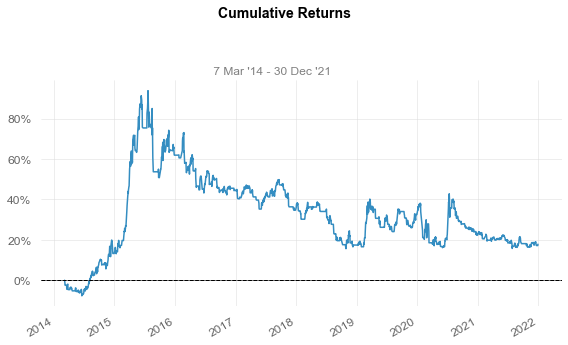

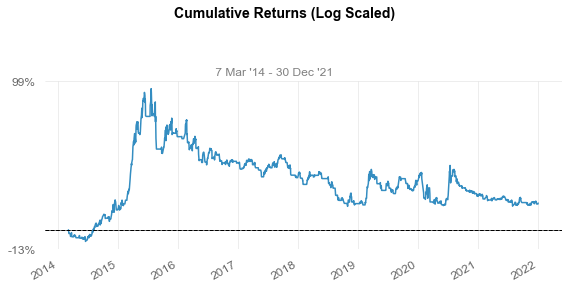

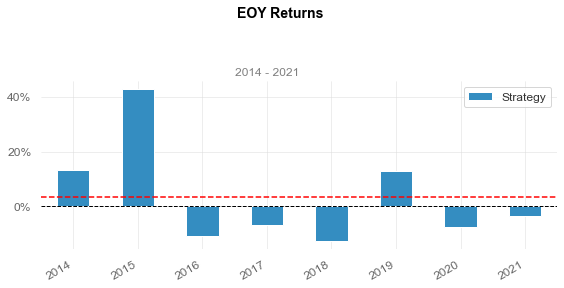

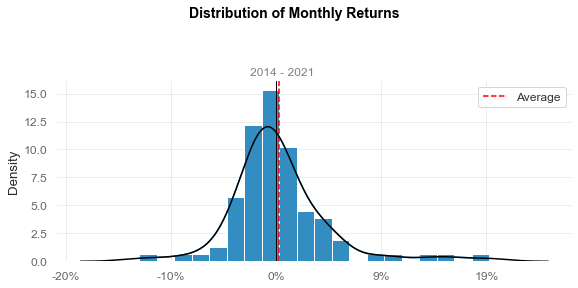

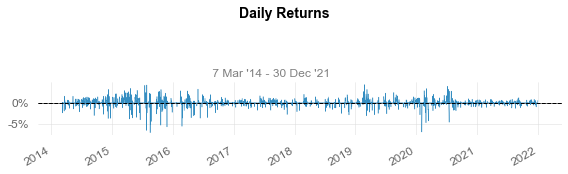

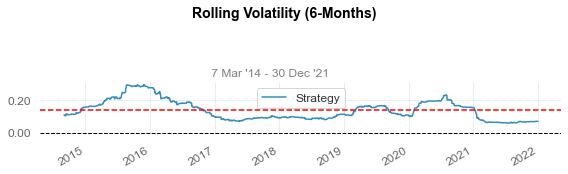

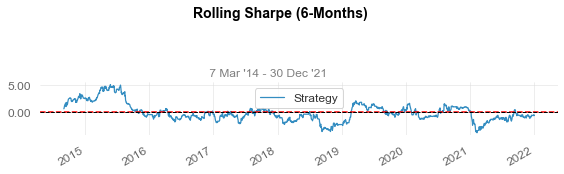

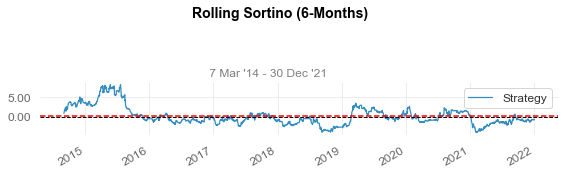

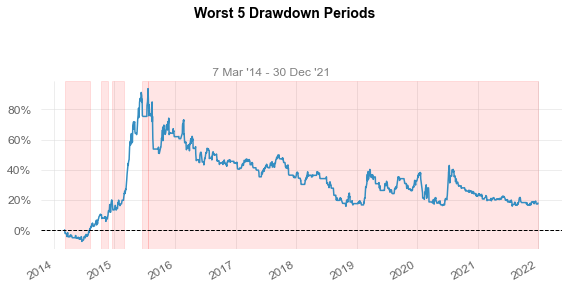

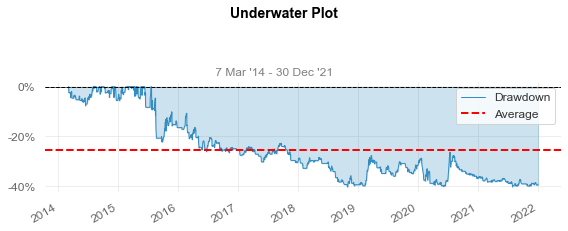

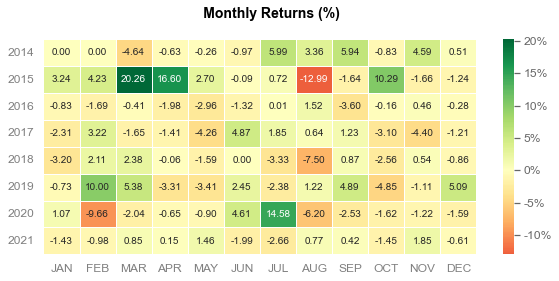

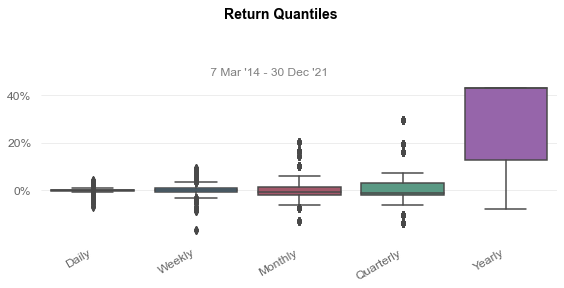

In [6]:
# 画图仍只能在notebook中输出
qs.reports.full(returns, benchmark=None, rf=0.0,
                grayscale=False, display=True, compounded=True)